# Import libraries

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import plotly.graph_objects as go

import os
import warnings



In [2]:
plt.style.use('seaborn')

plt.rcParams['figure.figsize'] = (16, 4)

custom_colors = ['#512d6d', '#e6a2b4', '#6b7d96', '#b3cde0']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=custom_colors)

# Download file

In [3]:
file_id = "1atOZX3YXmxx-_QebbTfndeC6U_DPTL2e" # ID of the file on Google Drive
file_name = 'Updated_data_2021&2022.csv'

%run download.ipynb

# Import data

In [4]:
# File path
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
file_path = os.path.join(parent_dir, 'Data',file_name)

df = pd.read_csv(file_path)
df.head()

,DATE_DIM,DAY_OF_WEEK,BET_ACCOUNT_NUM_HASH,AGE,AGE_BAND,GENDER,TENURE_IN_DAYS,RESIDENTIAL_STATE,FOB_RACING_TURNOVER,FOB_SPORT_TURNOVER,PARI_RACING_TURNOVER,PARI_SPORT_TURNOVER,TOTAL_TURNOVER,DIVIDENDS_PAID,GROSS_MARGIN,TICKETS
0,2021-01-01,Fri,13154,67.00,65+,M,11846,WA,37.00,NaN,1081.00,NaN,1118.00,443.55,271.25,288
1,2021-01-01,Fri,18379,54.00,45-54,M,1884,WA,40.00,NaN,NaN,NaN,40.00,0.00,40.00,1
2,2021-01-01,Fri,559232,63.00,55-64,M,2866,WA,NaN,NaN,12.00,NaN,12.00,9.50,2.04,5
3,2021-01-01,Fri,698904,69.00,65+,M,2100,WA,NaN,NaN,1223.50,NaN,1223.50,267.91,245.12,40
4,2021-01-01,Fri,762921,67.00,65+,M,4766,WA,NaN,NaN,17.50,NaN,17.50,0.00,3.50,5


# EDA

### Column type conversion

In [5]:
# DATE_DIM: datetime
df['DATE_DIM'] = pd.to_datetime(df['DATE_DIM'], format='%Y-%m-%d')

# BET_ACCOUNT_NUM_HASH: string
df['BET_ACCOUNT_NUM_HASH'] = df['BET_ACCOUNT_NUM_HASH'].astype('O')

### Drop redundant columns

In [6]:
df.drop('DAY_OF_WEEK', axis=1, inplace=True)

### Missing value imputation

In [7]:
# No of missing values by columns
df.isna().sum()

DATE_DIM                       0
BET_ACCOUNT_NUM_HASH           0
AGE                         2676
AGE_BAND                       0
GENDER                         0
TENURE_IN_DAYS                 0
RESIDENTIAL_STATE              0
FOB_RACING_TURNOVER      3787445
FOB_SPORT_TURNOVER      10584521
PARI_RACING_TURNOVER     3836612
PARI_SPORT_TURNOVER     12348423
TOTAL_TURNOVER                 0
DIVIDENDS_PAID                 0
GROSS_MARGIN                   0
TICKETS                        0
dtype: int64

### Columns

In [8]:
df.columns

Index(['DATE_DIM', 'BET_ACCOUNT_NUM_HASH', 'AGE', 'AGE_BAND', 'GENDER',
       'TENURE_IN_DAYS', 'RESIDENTIAL_STATE', 'FOB_RACING_TURNOVER',
       'FOB_SPORT_TURNOVER', 'PARI_RACING_TURNOVER', 'PARI_SPORT_TURNOVER',
       'TOTAL_TURNOVER', 'DIVIDENDS_PAID', 'GROSS_MARGIN', 'TICKETS'],
      dtype='object')

### No of records

In [9]:
df.shape[0]

12364101

### Time period

In [10]:
df["DATE_DIM"].min().strftime("%Y/%m/%d")

'2021/01/01'

In [11]:
df["DATE_DIM"].max().strftime("%Y/%m/%d")

'2022/12/31'

2676 records are missing on 'AGE' column. Nan values on TURNOVER columns indicate zero value.

### Impute age column

In [12]:
# See if it is possble impute age using other rows from the same customer
missing_age_lst = df.loc[df['AGE'].isna(), 'BET_ACCOUNT_NUM_HASH'].unique()

df.loc[df['BET_ACCOUNT_NUM_HASH'].isin(missing_age_lst), 'BET_ACCOUNT_NUM_HASH'].drop_duplicates()

5145       1080370257
5768       1208532057
13803      2969320105
16044      3461584997
16286      3512123314
25592       786895907
34818      2100229039
208022     3387748523
395487     3111443700
1654462     708049310
Name: BET_ACCOUNT_NUM_HASH, dtype: object

Only 10 customers

In [13]:
# Impute age columns
age_mean = df.groupby('BET_ACCOUNT_NUM_HASH').AGE.min().mean() # 44

df['AGE'].fillna(age_mean, inplace=True)

### Create RACING_TURNOVER, SPORT_TURNOVER, FOB_TURNOVER, PARI_TURNOVER columns

In [14]:
df['FOB_TURNOVER'] = df[['FOB_RACING_TURNOVER','FOB_SPORT_TURNOVER']].sum(axis=1)
df['PARI_TURNOVER'] = df[['PARI_RACING_TURNOVER','PARI_SPORT_TURNOVER']].sum(axis=1)
df['RACING_TURNOVER'] = df[['FOB_RACING_TURNOVER','PARI_RACING_TURNOVER']].sum(axis=1)
df['SPORT_TURNOVER'] = df[['FOB_SPORT_TURNOVER','PARI_SPORT_TURNOVER']].sum(axis=1)

## TURNOVER

### Aggregate by day

In [15]:
# Aggregate by day
df_agg = df.set_index('DATE_DIM').resample('d')[['RACING_TURNOVER', 'SPORT_TURNOVER', 'FOB_TURNOVER', 'PARI_TURNOVER', 'TOTAL_TURNOVER', 'DIVIDENDS_PAID', 'GROSS_MARGIN', 'TICKETS']].sum()

# Preview
df_agg.head()

,RACING_TURNOVER,SPORT_TURNOVER,FOB_TURNOVER,PARI_TURNOVER,TOTAL_TURNOVER,DIVIDENDS_PAID,GROSS_MARGIN,TICKETS
DATE_DIM,,,,,,,,
2021-01-01,3675463.56,160299.45,1900648.00,1935115.01,3835763.01,3114833.37,612209.61,488315
2021-01-02,5908319.48,257615.55,3587422.50,2578512.53,6165935.03,4950862.44,1108761.73,698352
2021-01-03,1866557.48,331455.71,1262085.50,935927.69,2198013.19,1827063.93,329115.26,280743
2021-01-04,1201730.24,321881.93,908515.00,615097.17,1523612.17,1287379.59,199829.33,194844
2021-01-05,1255772.61,225060.21,827286.50,653546.32,1480832.82,1213781.16,251753.98,201685


### Correlation matrix

In [16]:
df_corr = df_agg.loc[:,'RACING_TURNOVER' : 'TICKETS'].corr()
df_corr

,RACING_TURNOVER,SPORT_TURNOVER,FOB_TURNOVER,PARI_TURNOVER,TOTAL_TURNOVER,DIVIDENDS_PAID,GROSS_MARGIN,TICKETS
RACING_TURNOVER,1.00,0.34,0.98,0.98,1.00,0.99,0.86,0.98
SPORT_TURNOVER,0.34,1.00,0.46,0.36,0.43,0.43,0.36,0.38
FOB_TURNOVER,0.98,0.46,1.00,0.94,0.99,0.99,0.81,0.96
PARI_TURNOVER,0.98,0.36,0.94,1.00,0.97,0.96,0.91,0.99
TOTAL_TURNOVER,1.00,0.43,0.99,0.97,1.00,1.00,0.86,0.98
DIVIDENDS_PAID,0.99,0.43,0.99,0.96,1.00,1.00,0.81,0.97
GROSS_MARGIN,0.86,0.36,0.81,0.91,0.86,0.81,1.00,0.90
TICKETS,0.98,0.38,0.96,0.99,0.98,0.97,0.90,1.00


<Axes: >

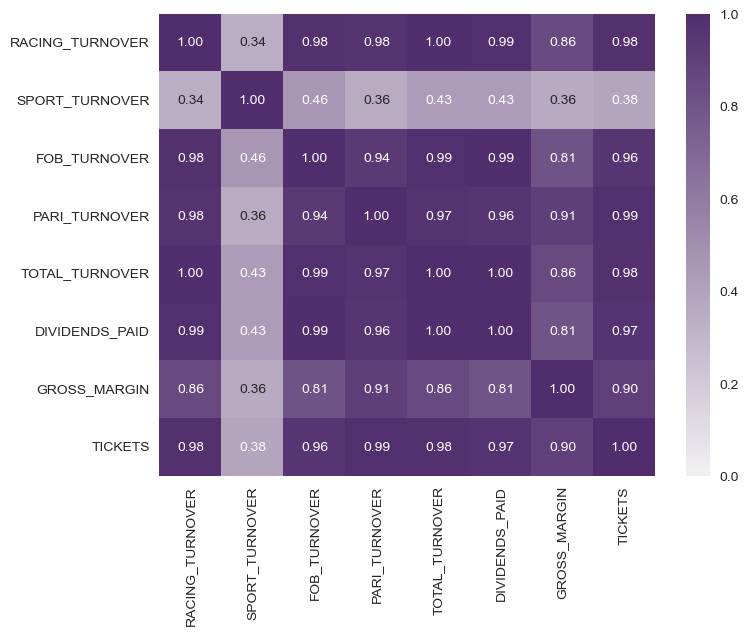

In [17]:
plt.figure(figsize=(8,6))
color = '#512d6d'

cmap = sns.light_palette("#512d6d", as_cmap=True)
sns.heatmap(df_corr, cmap=cmap, vmin=0, vmax=1 , annot=True, fmt=".2f")

We can see that other features heavily correlate with TOTAL_TURNOVER. Therefore, we will focus on TOTAL_TURNOVER as the representative of the business.

### 2021 vs 2022 trend

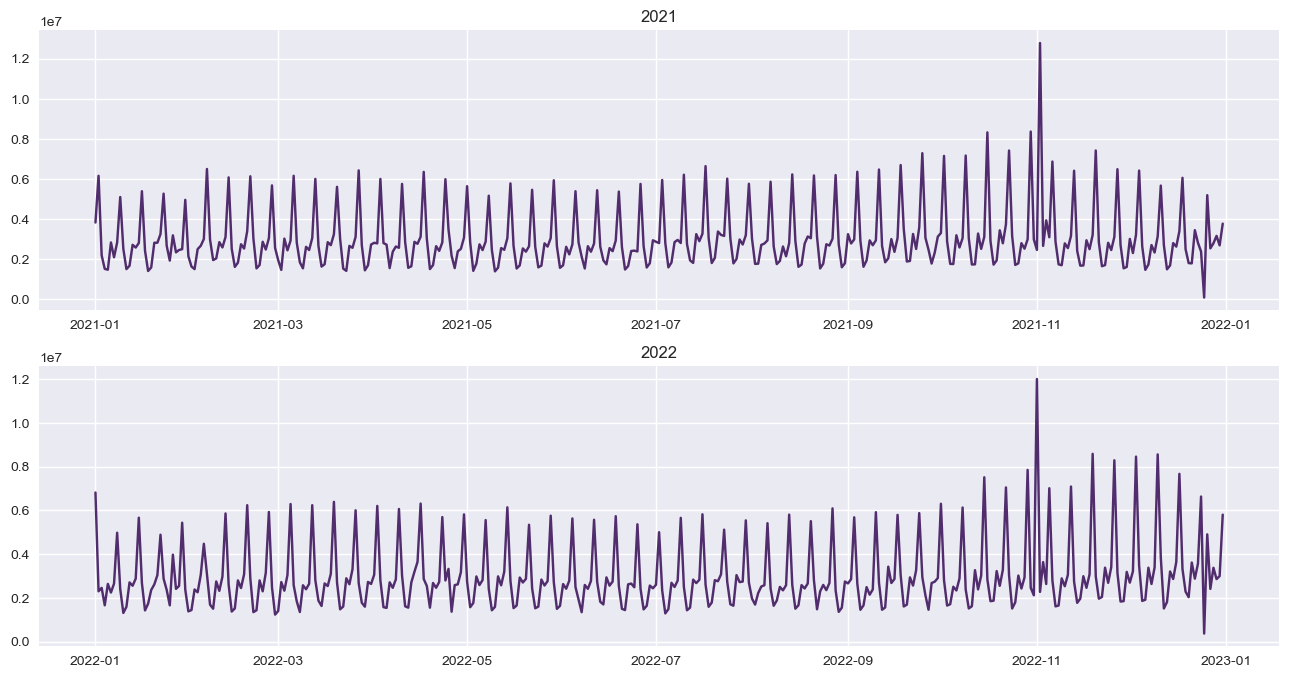

In [18]:
# 2021 vs 2022

df_agg_2021 = df_agg[df_agg.index.year == 2021]
df_agg_2022 = df_agg[df_agg.index.year == 2022]

# Visualize
fig, ax = plt.subplots(2, figsize=(16,8))

ax[0].plot(df_agg_2021['TOTAL_TURNOVER'], color= '#512d6d')
ax[0].set_title('2021')

ax[1].plot(df_agg_2022['TOTAL_TURNOVER'])
ax[1].set_title('2022')

plt.show()

There appears to be a weekly cycle throughout the year saved for some outliers

In [19]:
df_agg_2021['TOTAL_TURNOVER'].sum()

1103898720.44

In [20]:
df_agg_2022['TOTAL_TURNOVER'].sum()

1090983484.52

### Anomalies

In [21]:
# 2021
max_date = df_agg_2021.TOTAL_TURNOVER.argmax()
print(df_agg_2021.index[max_date])

min_date = df_agg_2021.TOTAL_TURNOVER.argmin()
print(df_agg_2021.index[min_date])

2021-11-02 00:00:00
2021-12-25 00:00:00


Two anomalies:
- Min day: Christmas day
- Max day: Melbourne Cup

In [22]:
# Compare two years starting from the first day of the first week of the year

first_monday_2021_index = df_agg_2021.index.weekday.to_list().index(0)
first_monday_2022_index = df_agg_2022.index.weekday.to_list().index(0)

df_agg_2021_filtered = df_agg_2021[first_monday_2021_index:]['TOTAL_TURNOVER'].reset_index(drop=True)
df_agg_2022_filtered = df_agg_2022[first_monday_2022_index:]['TOTAL_TURNOVER'].reset_index(drop=True)

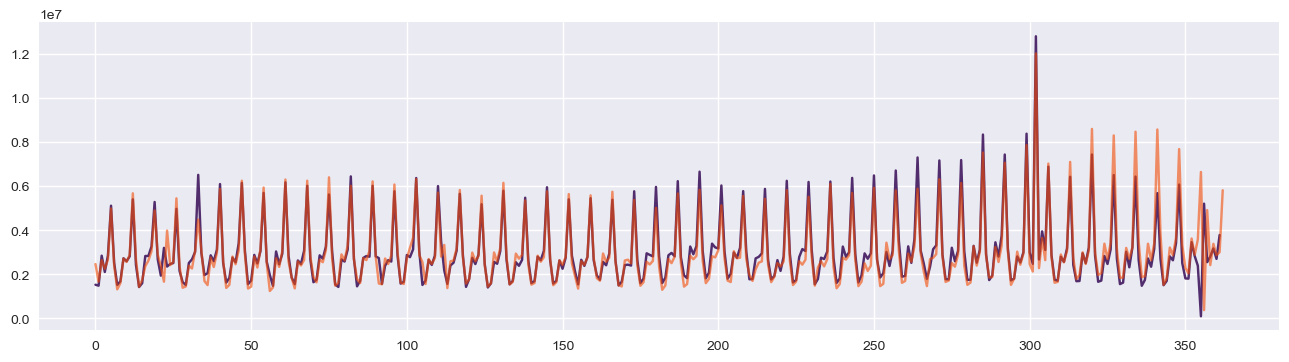

In [23]:
# Visualize
fig, ax = plt.subplots(1, figsize=(16,4))

ax.plot(df_agg_2021_filtered)
ax.plot(df_agg_2022_filtered, color = "#f44c05", alpha=0.6)

plt.show()

Pretty parallel

### Weekly cycle

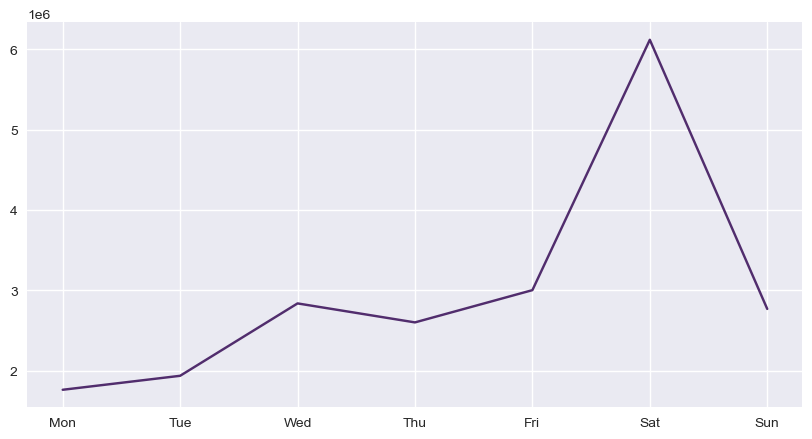

In [24]:
df_weekly = df_agg.groupby(df_agg.index.weekday).TOTAL_TURNOVER.mean()
df_weekly.index = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
fig, ax = plt.subplots(1, figsize=(10,5))
ax.plot(df_weekly)

### Average ticket price

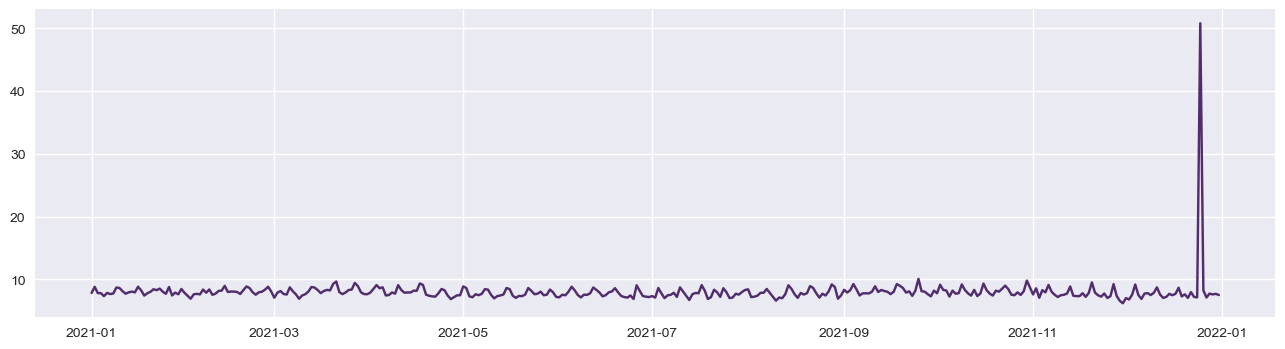

In [25]:
df_avg = df_agg['TOTAL_TURNOVER'] / df_agg['TICKETS']

fig, ax = plt.subplots(1, figsize=(16,4))

ax.plot(df_avg[:365])

plt.show()

In [26]:
df_avg[[df_avg[:365].argmax()]]

DATE_DIM
2021-12-25   50.83
Freq: D, dtype: float64

### Gross margin

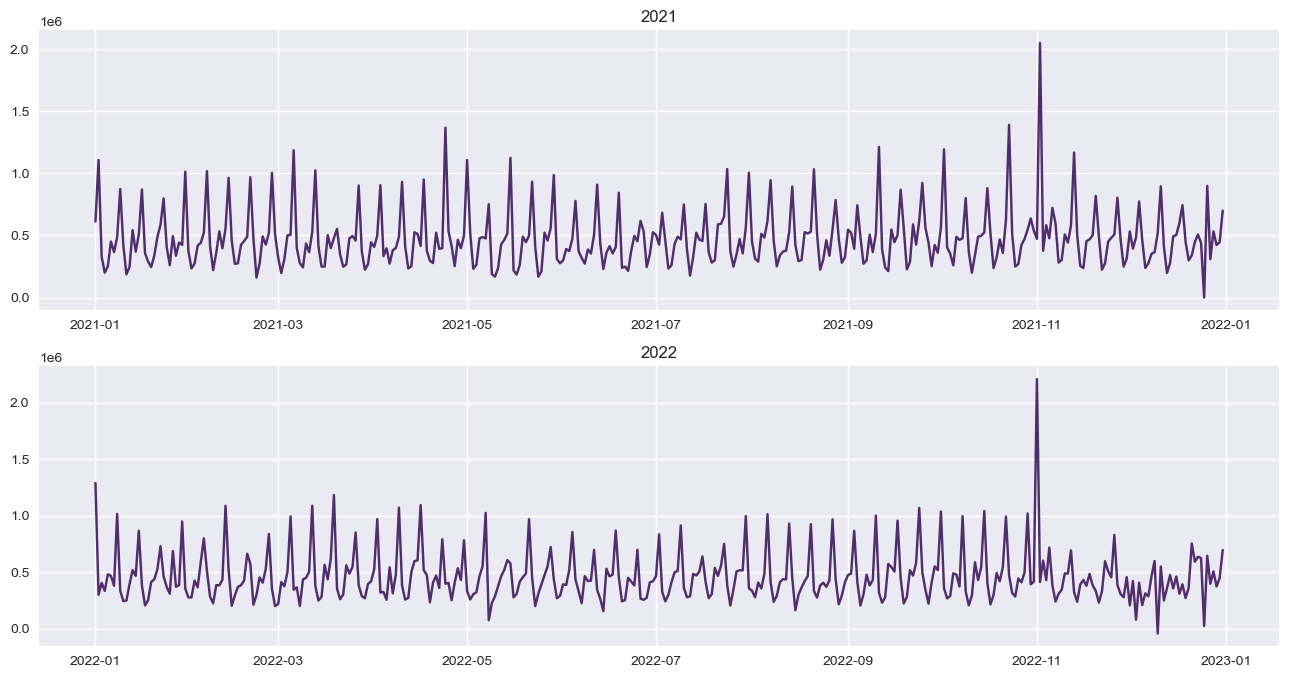

In [27]:
# Visualize
fig, ax = plt.subplots(2, figsize=(16,8))

ax[0].plot(df_agg_2021['GROSS_MARGIN'])
ax[0].set_title('2021')

ax[1].plot(df_agg_2022['GROSS_MARGIN'])
ax[1].set_title('2022')

plt.show()

### DIVIDENDS PAID

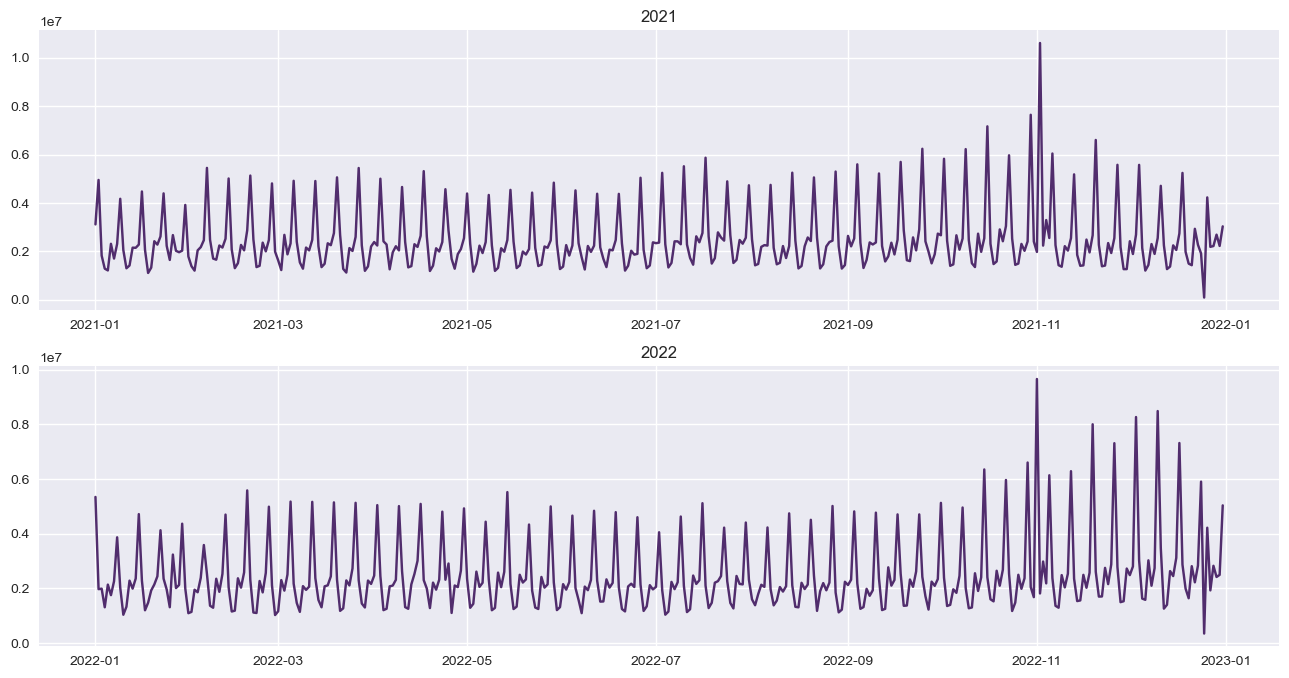

In [28]:
# Visualize
fig, ax = plt.subplots(2, figsize=(16,8))

ax[0].plot(df_agg_2021['DIVIDENDS_PAID'])
ax[0].set_title('2021')

ax[1].plot(df_agg_2022['DIVIDENDS_PAID'])
ax[1].set_title('2022')

plt.show()

### Dividends paid / total turnover

In [29]:
df_div_per =  df_agg_2022['DIVIDENDS_PAID'] / df_agg_2022['TOTAL_TURNOVER'] * 100

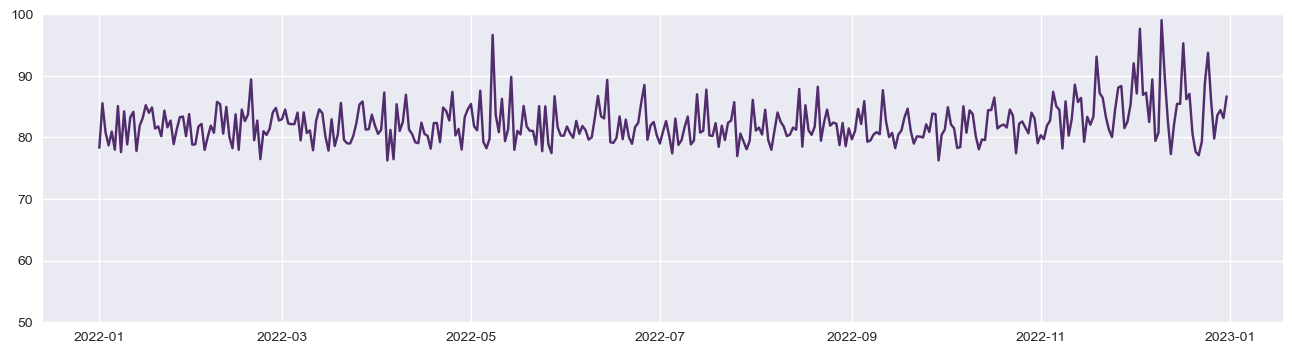

In [30]:
fig, ax = plt.subplots(1, figsize=(16,4))

ax.plot(df_div_per)
ax.set_ylim((50,100))
    
plt.show()

In [31]:
df_div_per.var()

11.283676962842934

In [32]:
df_div_per.mean()

82.29626539722426

(array([13., 45., 77., 76., 56., 41., 25., 17.,  7.,  1.,  1.,  2.,  1.,
         1.,  2.]),
 array([76.26401049, 77.78265642, 79.30130235, 80.81994828, 82.33859422,
        83.85724015, 85.37588608, 86.89453201, 88.41317794, 89.93182387,
        91.4504698 , 92.96911573, 94.48776166, 96.00640759, 97.52505352,
        99.04369946]),
 <BarContainer object of 15 artists>)

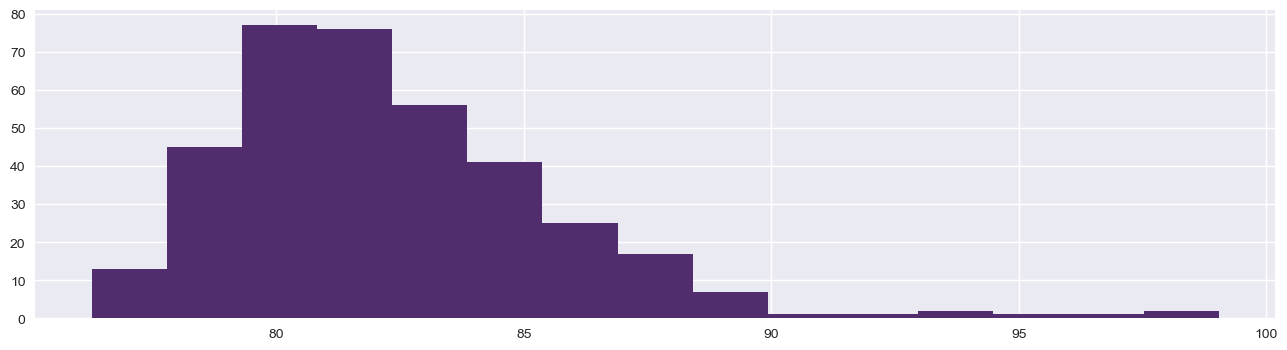

In [33]:
plt.hist(df_div_per, bins=15)

### RACING_TURNOVER vs SPORT_TURNOVER


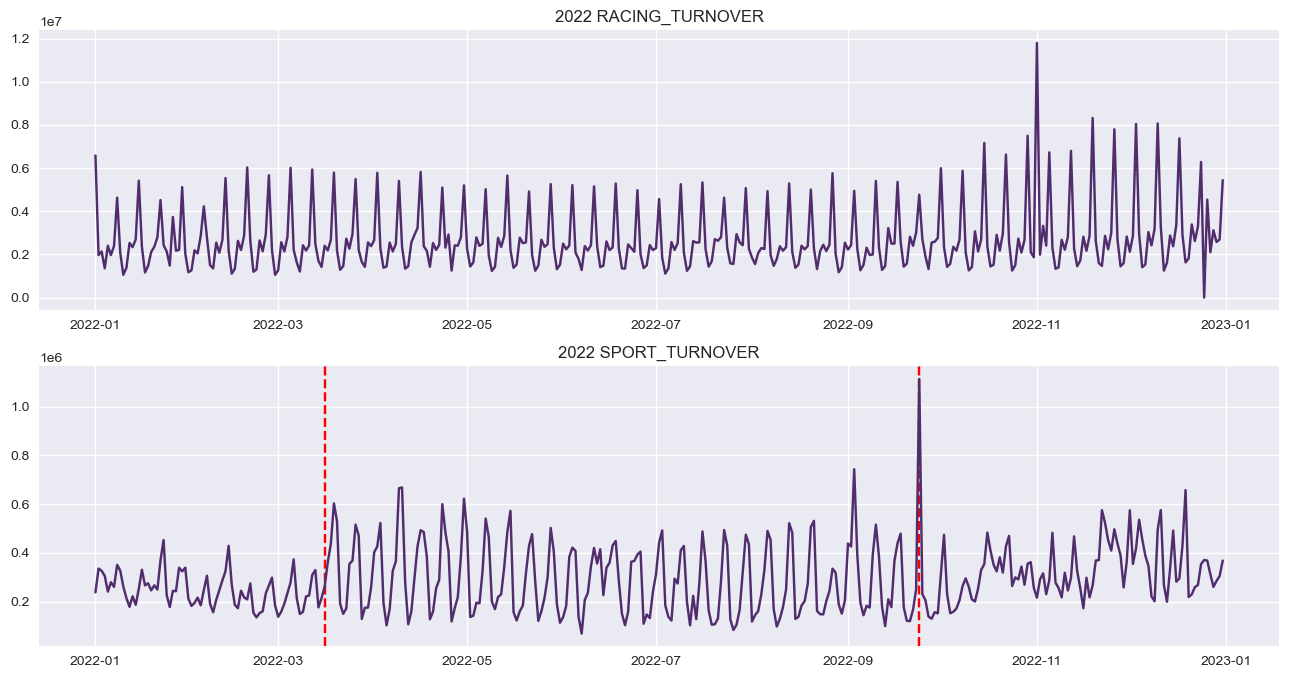

In [34]:
## 2022: RACING_TURNOVER vs SPORT_TURNOVER

fig, ax = plt.subplots(2, figsize=(16,8))

ax[0].plot(df_agg_2022['RACING_TURNOVER'])
ax[0].set_title('2022 RACING_TURNOVER')

threshold_1 = datetime(2022, 3, 16)
threshold_2 = datetime(2022, 9, 24)
threshold_mpl_1 = mdates.date2num(threshold_1)
threshold_mpl_2 = mdates.date2num(threshold_2)

ax[1].axvline(threshold_mpl_1 , color='red', linestyle='--')
ax[1].axvline(threshold_mpl_2 , color='red', linestyle='--')

ax[1].plot(df_agg_2022['SPORT_TURNOVER'])
ax[1].set_title('2022 SPORT_TURNOVER')

plt.show()

Surge during AFL Season: 2022-03-16 -> 2021-09-24. Final is on the last day.

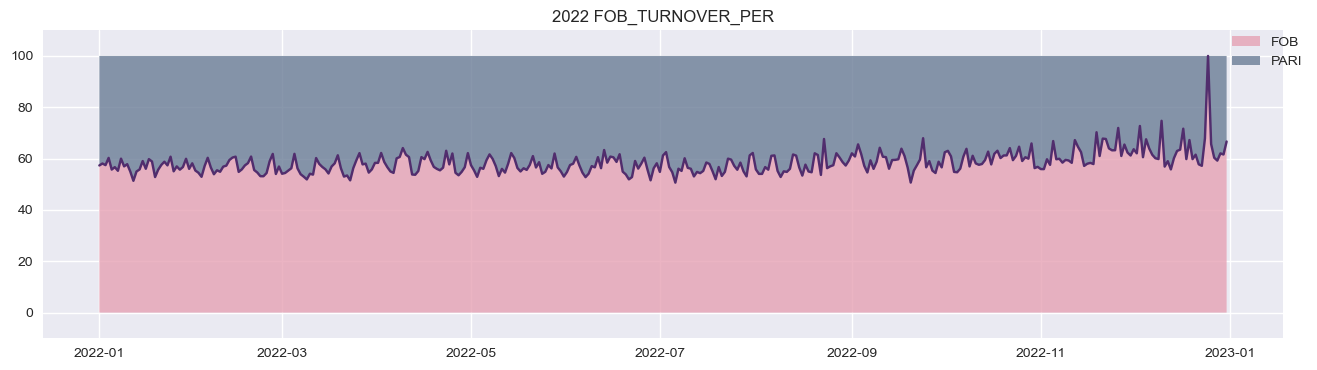

In [49]:
## 2022: FOB vs PARI ratio

fig, ax = plt.subplots(1, figsize=(16,4))

df_agg_2022['FOB_TURNOVER_PER'] = df_agg_2022['FOB_TURNOVER'] / df_agg_2022['TOTAL_TURNOVER'] * 100
df_agg_2022['PARI_TURNOVER_PER'] = 100 - df_agg_2022['FOB_TURNOVER_PER']

ax.plot(df_agg_2022['FOB_TURNOVER_PER'])
plt.stackplot(df_agg_2022.index, df_agg_2022['FOB_TURNOVER_PER'], df_agg_2022['PARI_TURNOVER_PER'], labels=['FOB', 'PARI'], alpha=0.8)

ax.set_title('2022 FOB_TURNOVER_PER')
ax.legend(loc='best', bbox_to_anchor=(1.02, 1), borderaxespad=0)
ax.set_ylim(-10,110)

plt.show()

## EDA Customer

In [50]:
# Aggregate data
cus_df = df.groupby('BET_ACCOUNT_NUM_HASH', as_index=False) \
            .agg({'AGE': max, 
                  'GENDER': max,
                  'TENURE_IN_DAYS' : min,
                  'RESIDENTIAL_STATE' : min, 
                  'DATE_DIM': [min, max, np.size],
                  'RACING_TURNOVER' : sum, 
                  'SPORT_TURNOVER' : sum, 
                  'FOB_TURNOVER' : sum, 
                  'PARI_TURNOVER' : sum, 
                  'TOTAL_TURNOVER' : sum, 
                  'DIVIDENDS_PAID' : sum,
                  'GROSS_MARGIN' : sum, 
                  'TICKETS' : sum})

# Rename columns
cus_df.columns = ["_".join(x).upper() if x[0] == "DATE_DIM" else x[0] for x in cus_df.columns.ravel() ]

cus_df.head()

,BET_ACCOUNT_NUM_HASH,AGE,GENDER,TENURE_IN_DAYS,RESIDENTIAL_STATE,DATE_DIM_MIN,DATE_DIM_MAX,DATE_DIM_SIZE,RACING_TURNOVER,SPORT_TURNOVER,FOB_TURNOVER,PARI_TURNOVER,TOTAL_TURNOVER,DIVIDENDS_PAID,GROSS_MARGIN,TICKETS
0,13154,67.00,M,11846,WA,2021-01-01,2022-12-31,463,366186.08,0.00,31113.00,335073.08,366186.08,270817.07,81925.97,113627
1,18379,54.00,M,1884,WA,2021-01-01,2022-12-31,199,31934.00,99.00,28021.00,4012.00,32033.00,23658.86,6645.73,841
2,37251,22.00,U,0,WA,2022-11-01,2022-11-01,1,100.00,0.00,65.00,35.00,100.00,760.00,-689.65,7
3,129273,22.00,U,0,WA,2021-12-26,2022-12-19,16,62.00,93.00,155.00,0.00,155.00,149.45,5.55,37
4,348318,29.00,U,0,WA,2022-06-10,2022-09-24,4,25.00,5.00,27.00,3.00,30.00,0.00,27.58,17


### Unique customers

In [51]:
print("Total unique customers : ", cus_df.shape[0])

print("Total unique customers in 2021 : ", df.loc[df['DATE_DIM'].dt.year == 2021, 'BET_ACCOUNT_NUM_HASH'].nunique())

print("Total unique customers in 2022 : ", df.loc[df['DATE_DIM'].dt.year == 2022, 'BET_ACCOUNT_NUM_HASH'].nunique())

Total unique customers :  144869
Total unique customers in 2021 :  110526
Total unique customers in 2022 :  116488


In [52]:
# Describe
cus_df.describe()

,AGE,TENURE_IN_DAYS,DATE_DIM_SIZE,RACING_TURNOVER,SPORT_TURNOVER,FOB_TURNOVER,PARI_TURNOVER,TOTAL_TURNOVER,DIVIDENDS_PAID,GROSS_MARGIN,TICKETS
count,144869.00,144869.00,144869.00,144869.00,144869.00,144869.00,144869.00,144869.00,144869.00,144869.00,144869.00
mean,43.68,1658.01,85.35,13576.28,1574.53,8887.54,6263.27,15150.81,12523.23,2365.25,1888.10
std,15.92,2442.81,142.07,55650.13,22389.91,47372.95,28983.57,61880.88,54210.64,9365.92,8882.06
min,18.00,-1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,-327327.36,1.00
25%,31.00,2.00,3.00,100.00,0.00,75.00,11.00,163.00,73.10,20.00,17.00
50%,41.00,787.00,18.00,722.00,5.00,491.00,138.00,992.25,738.13,150.00,101.00
75%,55.00,2227.00,98.00,5962.00,139.00,3604.00,1493.00,7067.81,5904.35,1060.38,700.00
max,104.00,20600.00,730.00,5234120.84,2849523.33,4399559.00,3599772.50,5544861.46,4507251.65,467391.88,699955.00


### Correlation matrix

In [53]:
col_list = ['AGE' , 'TENURE_IN_DAYS', 'DATE_DIM_SIZE' , 'RACING_TURNOVER', 'SPORT_TURNOVER', 'FOB_TURNOVER', 'PARI_TURNOVER', 'TOTAL_TURNOVER',
            'DIVIDENDS_PAID', 'GROSS_MARGIN' , 'TICKETS']

cus_corr_df = cus_df[col_list].corr()

<Axes: >

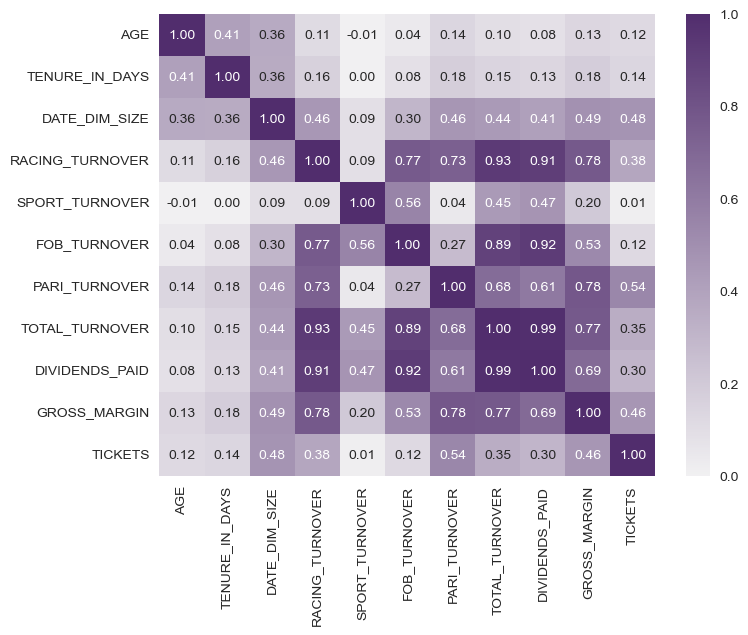

In [54]:
plt.figure(figsize=(8,6))

color = '#512d6d'
cmap = sns.light_palette("#512d6d", as_cmap=True)

sns.heatmap(cus_corr_df, cmap=cmap, vmin=0, vmax=1, annot=True, fmt=".2f")

### Age

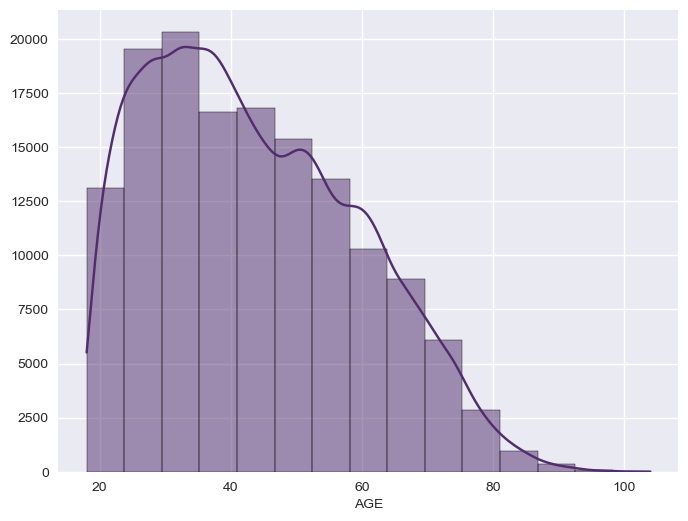

In [55]:
# Age distribution
plt.figure(figsize=(8,6))
sns.histplot(cus_df['AGE'], kde=True, bins=15)
plt.ylabel("")

plt.show();

Pretty normal with a right tail

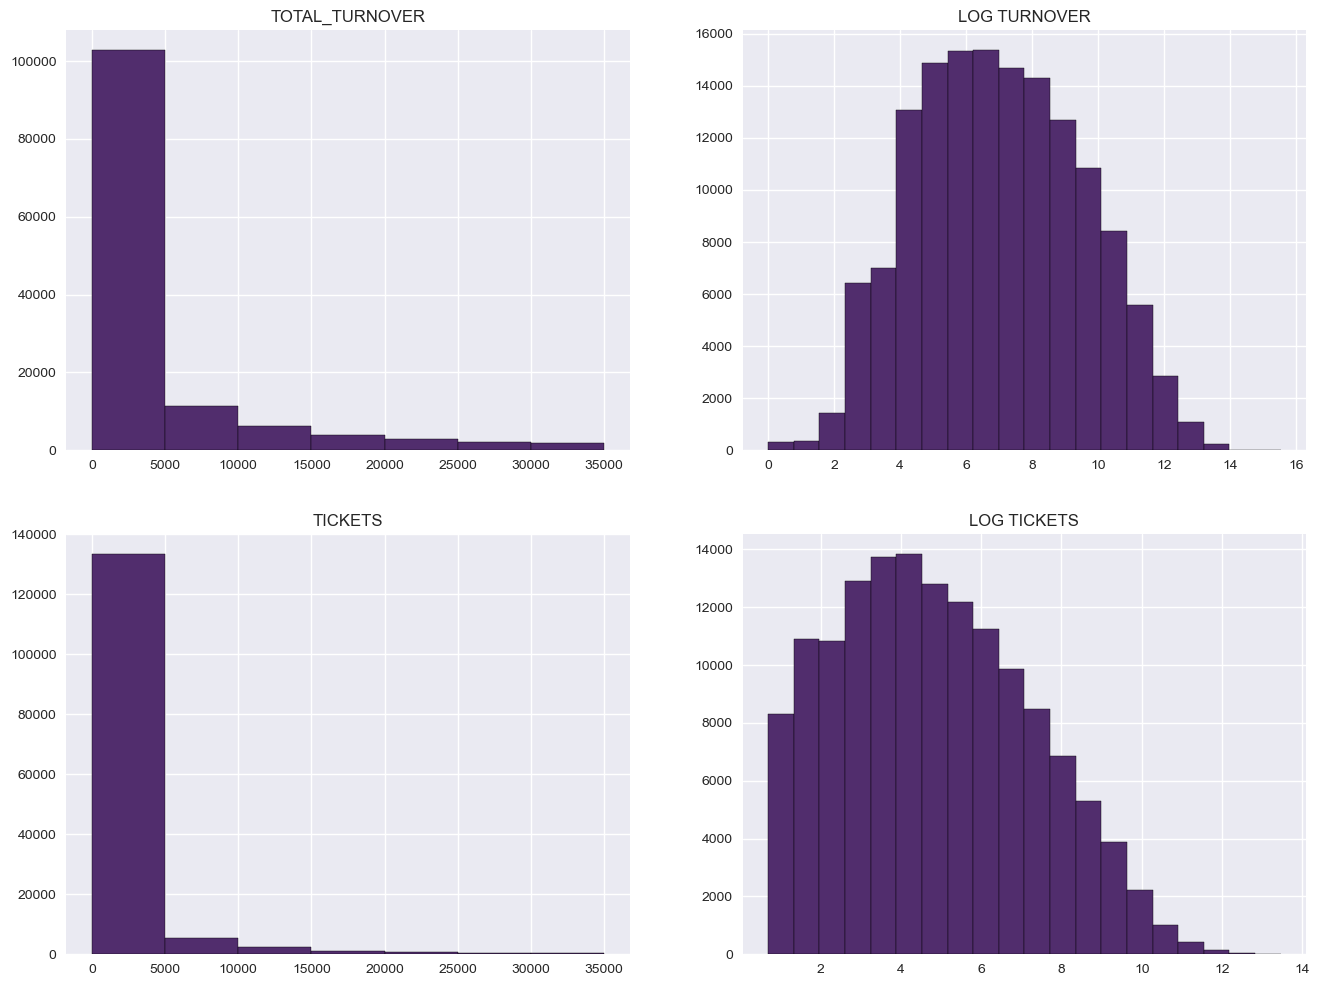

In [56]:
# TURNOVER and TICKETS
fig, ax = plt.subplots(2,2, figsize=(16,12))

ax[0,0].hist(cus_df['TOTAL_TURNOVER'], bins=range(0,40000, 5000), edgecolor='black')
ax[0,0].set_title('TOTAL_TURNOVER')

ax[0,1].hist(np.log(cus_df['TOTAL_TURNOVER']+1), bins=20, edgecolor='black')
ax[0,1].set_title('LOG TURNOVER')

ax[1,0].hist(cus_df['TICKETS'], bins=range(0,40000, 5000), edgecolor='black')
ax[1,0].set_title('TICKETS')

ax[1,1].hist(np.log(cus_df['TICKETS']+1), bins=20, edgecolor='black')
ax[1,1].set_title('LOG TICKETS')

plt.show();

We notice exponential decays with these two distributions. Therefore, a log transformation would work great here to convert the distribution in Gaussian when modelingm.

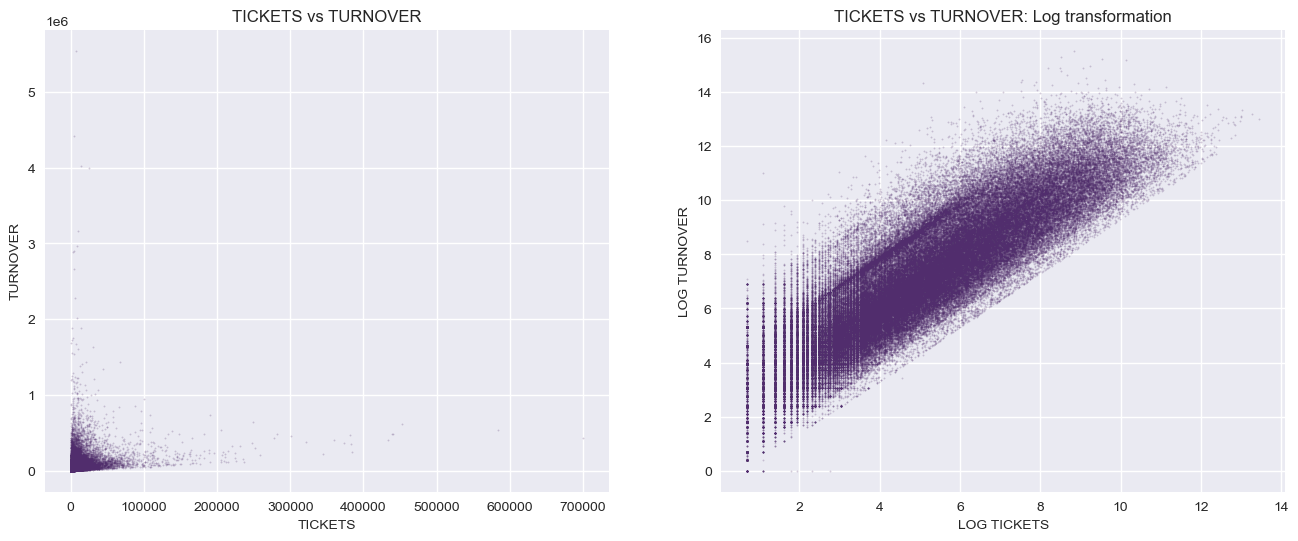

In [57]:
fig, ax = plt.subplots(1,2, figsize=(16,6))

ax[0].scatter(cus_df['TICKETS'] , cus_df['TOTAL_TURNOVER'] , s=1, alpha=0.2)
ax[0].set_title('TICKETS vs TURNOVER')
ax[0].set_xlabel('TICKETS')
ax[0].set_ylabel('TURNOVER')

ax[1].scatter(np.log(cus_df['TICKETS']+1) , np.log(cus_df['TOTAL_TURNOVER']+1) , s=1, alpha=0.2)
ax[1].set_title('TICKETS vs TURNOVER: Log transformation')
ax[1].set_xlabel('LOG TICKETS')
ax[1].set_ylabel('LOG TURNOVER')

plt.show()

In [61]:
#LOG TURNOVER and LOG TICKETS corr
np.corrcoef(np.log(cus_df['TOTAL_TURNOVER']+1), np.log(cus_df['TICKETS']+1))[0,1]

0.8778874226852929

We detect strong heteroscedascity between TICKETS and TURNOVER (left fig). Therefore, we log transform both columns to achieve balanced variance (right fig).

Log transformation doesn't work as well here.

### TURNOVER vs DIVIDENDS_PAID 

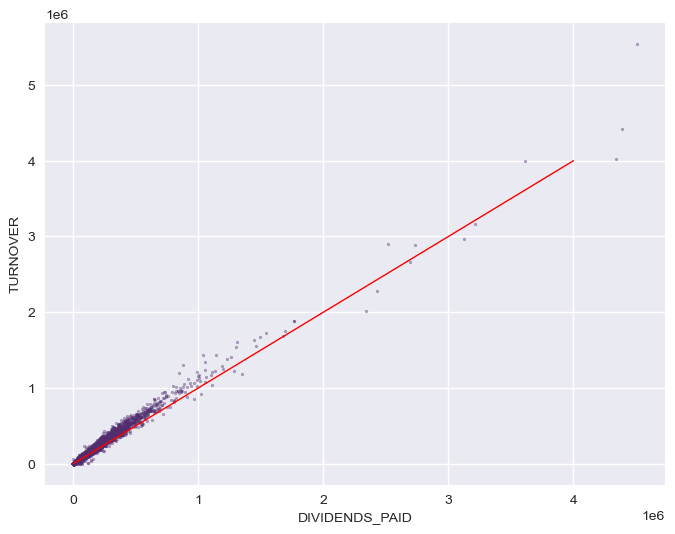

In [62]:
plt.figure(figsize=(8,6))

plt.scatter(cus_df['DIVIDENDS_PAID'], cus_df['TOTAL_TURNOVER'], s=4, alpha=0.4)
plt.plot([0, 4e6], [0, 4e6], linewidth=1, c='r' )

plt.xlabel('DIVIDENDS_PAID')
plt.ylabel('TURNOVER')
plt.show();

DIVIDENDS_PAID almost completely linearly correlate with TURNOVER. GROSS_MARGIN has a considerably strong correlation with TURNOVER too. AGE and TICKETS appear to be weakly related to TURNOVER.

I might seem that the more you invest, the bigger you win. That's only half of the story. The red line indicates the break even boundary. We have to analyze the variance to truly understand the risk.

### AGE vs TURNOVER

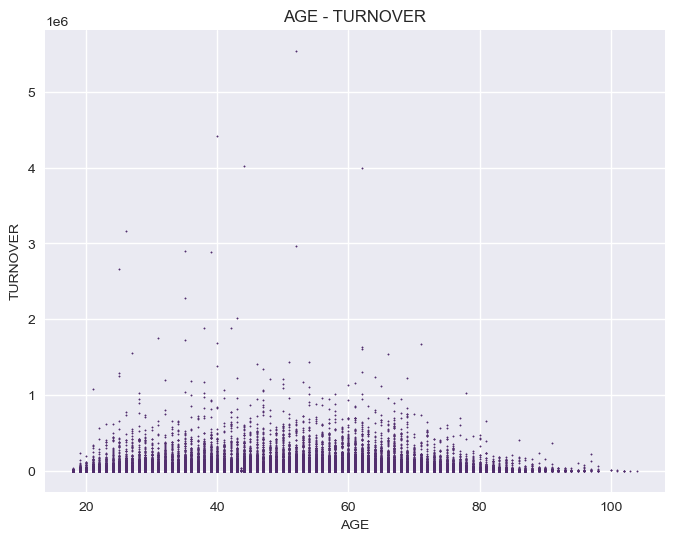

In [63]:
plt.figure(figsize=(8,6))

plt.scatter(cus_df['AGE'] , cus_df['TOTAL_TURNOVER'] , s=1)
plt.title('AGE - TURNOVER')
plt.xlabel('AGE')
plt.ylabel('TURNOVER')

plt.show()

No correllation

### RACING_TURNOVER vs SPORT_TURNOVER

In [64]:
cus_df[['RACING_TURNOVER', 'SPORT_TURNOVER']].sum(axis=0)

RACING_TURNOVER   1966781571.05
SPORT_TURNOVER     228100633.91
dtype: float64

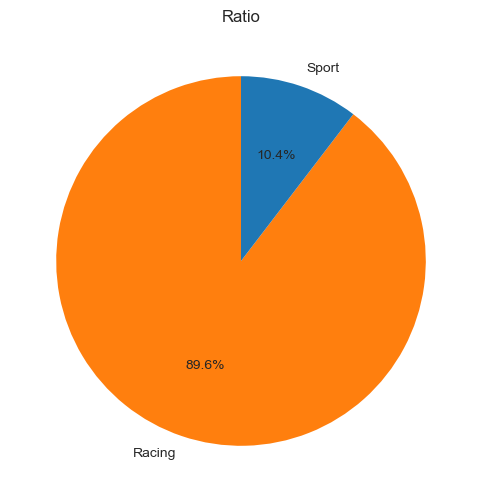

In [65]:
fig, ax = plt.subplots(1, figsize=(8,6))

colors = ['#FF7F0E', '#1F77B4']
ax.pie(cus_df[['RACING_TURNOVER', 'SPORT_TURNOVER']].sum(axis=0), labels= ["Racing", 'Sport'], colors=colors, autopct='%1.1f%%', startangle=90)
ax.set_title('Ratio')

plt.show();

Most people most of their money on horse racing instead of other sports (most presumingly Australian football). However, tt's noteworthy to point out that a considerable amount of customers like to spend 90% of their money on other sports. 

In [66]:
plt.figure(figsize=(16,4))

cus_num_df = df.set_index('DATE_DIM').resample('d').BET_ACCOUNT_NUM_HASH.size()

cus_num_df[:365].plot()

MemoryError: Unable to allocate 1.11 GiB for an array with shape (12, 12364101) and data type float64

<Figure size 1600x400 with 0 Axes>

Weekly cycle. High on the weekends.